In [2]:
import pandas as pd
import numpy as np
import chess
import chess.engine
import re
import matplotlib.pyplot as plt

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Load the dataset from the image file
data = pd.read_csv(r'C:\Users\Admin\AIP\tactic_evals.csv')

In [5]:
data.head()

,FEN,Evaluation,Move
0,r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...,#+2,d3g6
1,r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...,#+1,c2g6
2,r2qkbr1/pb1nn3/1ppp2Bp/8/3P1p2/2P2N1P/PPQN1PP1...,#+1,g8g6
3,8/7p/R5p1/2p1pkP1/7P/P4PK1/1r6/3q4 w - - 6 46,#+1,a6f6
4,6k1/pp6/3p4/2p1p3/2P1P1q1/1P1P2pP/P5P1/5K2 w -...,+408,h3g4


In [7]:
data

,FEN,Evaluation,Move
0,r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...,#+2,d3g6
1,r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...,#+1,c2g6
2,r2qkbr1/pb1nn3/1ppp2Bp/8/3P1p2/2P2N1P/PPQN1PP1...,#+1,g8g6
3,8/7p/R5p1/2p1pkP1/7P/P4PK1/1r6/3q4 w - - 6 46,#+1,a6f6
4,6k1/pp6/3p4/2p1p3/2P1P1q1/1P1P2pP/P5P1/5K2 w -...,+408,h3g4
...,...,...,...
2628214,3r4/3pk3/6q1/Qp1pPpP1/1PbPn3/4B3/5RKP/8 w - - ...,-1053,a5a3
2628215,r2qkbnr/5ppp/p1p1p3/3p4/3P2PP/2N5/PPb1QP2/R1B1...,+215,h7h5
2628216,Q5b1/6pk/3q1pNp/1p1p3N/3P1P2/2P5/1P3KPP/8 b - ...,+944,h7g6
2628217,3rb3/ppk1r2p/6p1/2P5/4B3/P7/6PP/3Q3K w - - 0 35,-692,d1c2


# FEN Notation to Vector
    #piece placement - lowercase for black pieces, uppercase for white pieces. numbers represent consequtive spaces. / represents a new row 
    # active color - whose turn it is, either 'w' or 'b'
    # castling rights - which castling moves are still legal K or k for kingside and Q or q for queenside, '-' if no legal castling moves for either player
    # en passant - if the last move was a pawn moving up two squares, this is the space behind the square for the purposes of en passant
    # halfmove clock - number of moves without a pawn move or piece capture, after 50 of which the game is a draw
    # fullmove number - number of full turns starting at 1, increments after black's move

In [8]:
import numpy as np
import re
import chess

def fen_to_bit_vector(fen):
    parts = re.split(" ", fen)
    piece_placement = re.split("/", parts[0])
    active_color = parts[1]
    castling_rights = parts[2]
    en_passant = parts[3]
    halfmove_clock = int(parts[4])
    fullmove_clock = int(parts[5])

    bit_vector = np.zeros((14, 8, 8), dtype=np.uint8)

    # piece to layer structure taken from reference [1]
    piece_to_layer = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }

    for r, row in enumerate(piece_placement):
        c = 0
        for piece in row:
            if piece in piece_to_layer:
                bit_vector[piece_to_layer[piece], r, c] = 1
                c += 1
            else:
                c += int(piece)

    # Encode castling rights in a specific layer (layer 12)
    castling_positions = {'K': (7, 7), 'Q': (7, 0), 'k': (0, 7), 'q': (0, 0)}
    for right in castling_rights:
        if right in castling_positions:
            bit_vector[12, castling_positions[right][0], castling_positions[right][1]] = 1

    # Encode en passant square (layer 13)
    if en_passant != '-':
        en_passant_index = chess.parse_square(en_passant)
        ep_row, ep_col = np.unravel_index(en_passant_index, (8, 8))
        bit_vector[13, 7 - ep_row, ep_col] = 1

    return bit_vector

In [9]:
def standardize_evaluation(value, min_value, max_value):
    try:
        value = float(value)
    except ValueError:
        cleaned_value = value.lstrip('#')
        try:
            numeric_value = float(cleaned_value)
            value = numeric_value * 15000
        except ValueError:
            print("cannot clean")
    standardized_value = (value - min_value) / (max_value - min_value)
    return standardized_value

In [10]:
def square_to_index(square):
    letter = chess.square_name(square)
    row = 8 - int(letter[1])
    column = board_positions[letter[0]]
    return row, column

In [11]:
def boards_to_matrices_batch(boards):
    batch_size = len(boards)
    board_3d_batch = np.zeros((batch_size, 14, 8, 8), dtype=np.int8)

    for b_idx, board in enumerate(boards):
        for piece in chess.PIECE_TYPES:
            for square in board.pieces(piece, chess.WHITE):
                index = np.unravel_index(square, (8, 8))
                board_3d_batch[b_idx, piece - 1, 7 - index[0], index[1]] = 1
            for square in board.pieces(piece, chess.BLACK):
                index = np.unravel_index(square, (8, 8))
                board_3d_batch[b_idx, piece + 5, 7 - index[0], index[1]] = 1

        aux = board.turn
        board.turn = chess.WHITE
        for move in board.legal_moves:
            i, j = np.unravel_index(move.to_square, (8, 8))
            board_3d_batch[b_idx, 12, 7 - i, j] = 1

        board.turn = chess.BLACK
        for move in board.legal_moves:
            i, j = np.unravel_index(move.to_square, (8, 8))
            board_3d_batch[b_idx, 13, 7 - i, j] = 1

        board.turn = aux

    return board_3d_batch

In [12]:
def process_batch(batch):
    valid_rows = batch.dropna(subset=['FEN', 'Evaluation'])
    y_evaluation = valid_rows['Evaluation'].apply(standardize_evaluation, args=(-10000, 10000)).values

    feature_boards = []
    for fen in valid_rows['FEN']:
        bit_vector = fen_to_bit_vector(fen)
        feature_boards.append(bit_vector)
    
    feature_board = np.stack(feature_boards, axis=0)
    return feature_board, y_evaluation

In [13]:
feature_board, y_evaluation = process_batch(data)

In [14]:
print("Feature board shape:", feature_board.shape)
print("Evaluations shape:", y_evaluation.shape)

Feature board shape: (2628219, 14, 8, 8)
Evaluations shape: (2628219,)


In [16]:
input_shape = (14, 8, 8)

In [19]:
def create_model(input_shape):
    model = models.Sequential([
          layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for advantage score
      ])

    model.compile(loss='mse', optimizer=Adam(learning_rate = 0.0001), metrics=['mse'])
    return model

# Create and compile the model
model = create_model(input_shape)


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
# Assuming you have your training data prepared as bit vectors and advantage scores
X_train, X_test, y_train, y_test = train_test_split(feature_board, y_evaluation, test_size=0.2, random_state=42)  

# Get input shape from training data
input_shape = X_train.shape[1:]

In [21]:
model = create_model(input_shape)
history=model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 830s 13ms/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.0906 - val_mse: 0.0906
Epoch 2/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 819s 12ms/step - loss: 0.0886 - mse: 0.0886 - val_loss: 0.0888 - val_mse: 0.0888
Epoch 3/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 790s 12ms/step - loss: 0.0876 - mse: 0.0876 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 4/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 616s 9ms/step - loss: 0.0857 - mse: 0.0857 - val_loss: 0.0866 - val_mse: 0.0866
Epoch 5/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 595s 9ms/step - loss: 0.0838 - mse: 0.0838 - val_loss: 0.0859 - val_mse: 0.0859
Epoch 6/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 727s 11ms/step - loss: 0.0839 - mse: 0.0839 - val_loss: 0.0852 - val_mse: 0.0852
Epoch 7/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 1826s 28ms/step - loss: 0.0822 - mse: 0.0822 - val_loss: 0.0843 - val_mse: 0.0843
Epoch 8/20
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 645s 10ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0838 - val_mse: 0.0838
E

In [22]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)
print("Test Mean Absolute Error (MAE):", mae)

16427/16427 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0817 - mse: 0.0817
Test Loss (MSE): 0.08182799071073532
Test Mean Absolute Error (MAE): 0.08182130008935928


In [23]:
# Predict the evaluations on the test set
y_pred = model.predict(X_test)

# Calculate additional metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Test Mean Squared Error (MSE):", mse)
print("Test Mean Absolute Error (MAE):", mae)

16427/16427 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step
Test Mean Squared Error (MSE): 0.08182140454241031
Test Mean Absolute Error (MAE): 0.12073868087324473


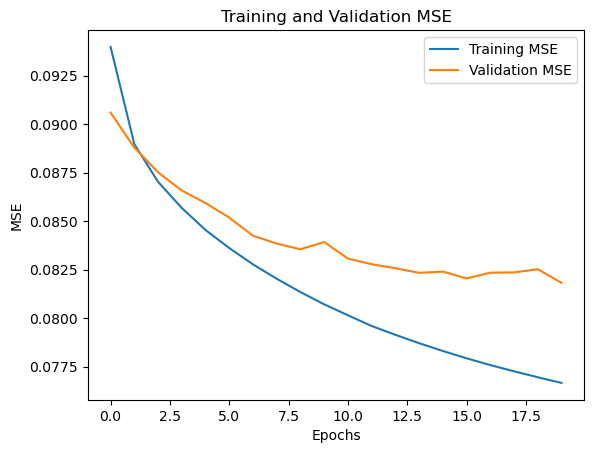

In [24]:
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [25]:
fen = 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 4'

# Preprocess the FEN string
bit_vector = fen_to_bit_vector(fen)
bit_vector = np.expand_dims(bit_vector, axis=0)  # Add batch dimension

# Predict the evaluation
predicted_evaluation = model.predict(bit_vector)
print(f"Predicted Evaluation: {predicted_evaluation[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Evaluation: 0.47465065121650696


In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class ChessHyperModel(HyperModel):
    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(14, 8, 8),
            padding='same'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
        model.add(layers.Conv2D(
            filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
            kernel_size=(3, 3),
            activation='relu',
            padding='same'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        model.add(layers.Flatten())
        model.add(layers.Dense(
            units=hp.Int('units', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            ),
            loss='mse',
            metrics=['mse']
        )
        return model

# Define the tuner
tuner = RandomSearch(
    ChessHyperModel(),
    objective='val_mse',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='chess_model_tuning'
)

# Sample data (replace with actual data)
x_train = np.random.random((100, 14, 8, 8))
y_train = np.random.random(100)
x_val = np.random.random((20, 14, 8, 8))
y_val = np.random.random(20)

# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
model.summary()

# Train the model
model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Trial 10 Complete [00h 00m 03s]
val_mse: 0.08835891634225845

Best val_mse So Far: 0.08489759266376495
Total elapsed time: 00h 00m 33s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 14, 8, 96)           │           7,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 4, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 4, 64)            │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 192)                 │          73,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,481 (533.13 KB)

 Trainable params: 136,481 (533.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0940 - mse: 0.0921 - val_loss: 0.1065 - val_mse: 0.1065
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0853 - mse: 0.0833 - val_loss: 0.0909 - val_mse: 0.0909
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0937 - mse: 0.0952 - val_loss: 0.0909 - val_mse: 0.0909
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0743 - mse: 0.0764 - val_loss: 0.1083 - val_mse: 0.1083
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0829 - mse: 0.0815 - val_loss: 0.0983 - val_mse: 0.0983


In [35]:
!pip install --upgrade numba

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/01/01/8b7b670c77c5ea0e47e283d82332969bf672ab6410d0b2610cac5b7a3ded/numba-0.60.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for llvmlite<0.44,>=0.43.0dev0 from https://files.pythonhosted.org/packages/df/41/73cc26a2634b538cfe813f618c91e7e9960b8c163f8f0c94a2b0f008b9da/llvmlite-0.43.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for numpy<2.1,>=1.22 from https://files.pythonhosted.org/packages/6a/1e/1d76829f03b7ac9c90e2b158f06b69cddf9a06b96667dd7e2d96acdc0593/numpy-2.0.0-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 60.9/60.9 kB ? eta 0:00:00
   ---------------------------------------- 2.7/2.7 MB 10.1 MB/s eta 0:00:00
   ---------------------------------------- 28.1/28.1 MB 13.6 MB/s eta 0:00:00
   ---------------------------------------- 16.5/1

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.0.0 which is incompatible.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip uninstall numba shap
!pip install numba shap


In [33]:
import shap

# Create a function to convert FEN to bit vector and add batch dimension
def fen_to_input(fen):
    bit_vector = fen_to_bit_vector(fen)
    bit_vector = np.expand_dims(bit_vector, axis=0)  # Add batch dimension
    return bit_vector

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, x_train)  # x_train should be your training data

# Explain a prediction
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
bit_vector = fen_to_input(fen)
shap_values = explainer.shap_values(bit_vector)

# Visualize the explanation
shap.image_plot(shap_values, bit_vector)


SystemError: initialization of _internal failed without raising an exception

# References
https://www.kaggle.com/code/utadcm0927/chess-position-evaluator